# Default Setup

In [1]:
# Dataloading Stuff
from google.colab import drive
from sys import path
import os

# Standard Stuff
!pip3 install numpy sklearn iterative-stratification pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Glove Stuff
from scipy import spatial
from sklearn.manifold import TSNE

# Use SS3 Repo
!rm -rf pyss3
!git clone https://github.com/sergioburdisso/pyss3.git

from pyss3.pyss3.__init__ import SS3
from pyss3.pyss3.util import Dataset, Evaluation, span

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
path_root = '/content/drive/My Drive/NLP Lab'
path.append(path_root)
data_root = '/data'
multi_label_dir = '/SB1_Train_Multilabel'

Cloning into 'pyss3'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 2032 (delta 30), reused 36 (delta 15), pack-reused 1966
Receiving objects: 100% (2032/2032), 101.89 MiB | 35.26 MiB/s, done.
Resolving deltas: 100% (1314/1314), done.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Load Data

In [2]:
attribute = True
if attribute:
  text, labels = Dataset.load_from_files_multilabel(path_root + data_root + multi_label_dir + '/attribute-text.txt', path_root + data_root + multi_label_dir + '/attribute-labels.txt', sep_label=';')
  X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size=0.3)
else:
  text, labels = Dataset.load_from_files_multilabel(path_root + data_root + multi_label_dir + '/entity-text.txt', path_root + data_root + multi_label_dir + '/entity-labels.txt', sep_label=';')
  X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size=0.3)

100%|██████████| 3748/3748 [00:00<00:00, 316519.38it/s]


In [3]:
pd.Series([label for attr_label in labels for label in attr_label]).value_counts()

general                  1802
quality                  1233
operation_performance     447
design_features           357
miscellaneous             260
usability                 229
prices                    177
style_options             156
price                     147
connectivity               55
portability                51
dtype: int64

## Load Glove Embeddings

In [4]:
# https://gist.github.com/EvolvedSquid/03b002ae0a623c2d2ecab378255b7aaa#file-get_closest_embeddings-py
embeddings_dict = {}
with open("/content/drive/My Drive/NLP Lab/data/glove.840B.300d.txt", 'r', encoding="utf-8") as files:
  for line in files:
    values = line.split()
    word = values[0]
    try:
      vector = np.asarray(values[1:], "float32")
      if len(vector) == 300: ## Unfortunately there are some entries not correct
        embeddings_dict[word] = vector
    except:
      print("Failed:", word, values[1])

Failed: . .
Failed: at name@domain.com
Failed: . .
Failed: to name@domain.com
Failed: . .
Failed: . .
Failed: email name@domain.com
Failed: or name@domain.com
Failed: contact name@domain.com
Failed: Email name@domain.com
Failed: on name@domain.com
Failed: At Killerseats.com
Failed: by name@domain.com
Failed: in mylot.com
Failed: emailing name@domain.com
Failed: Contact name@domain.com
Failed: at name@domain.com
Failed: • name@domain.com
Failed: at Amazon.com
Failed: is name@domain.com


## Get NLTK Stuff ready

In [5]:
!pip3 install nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk import download

download('stopwords')
download('punkt')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Tokenize and Filter Stopwords

In [6]:
def tokenize_samples(samples):
  return list(map(word_tokenize, samples))

def filter_stop_words(token_samples):
  return list(map(lambda x: [w for w in x if w not in stop_words], token_samples))

X_train_tok = tokenize_samples(X_train)
X_train_filtered = filter_stop_words(X_train_tok)

token_test = tokenize_samples(["This is a sample sentence, showing off the stop words filtration."])
filter_test = filter_stop_words(token_test)
filter_test

[['This',
  'sample',
  'sentence',
  ',',
  'showing',
  'stop',
  'words',
  'filtration',
  '.']]

## Enhance with words found by glove embedding

In [7]:
def find_closest_embeddings_word(embedding, num_words):
  return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))[1:num_words+1]

def enhance_with_glove_stupid(filtered_words, num_words):
  for sample in filtered_words:
    for word in sample:
      closest = find_closest_embeddings_word(embeddings_dict[word], num_words)
    return word, closest


def enhance_with_glove(filtered_words, num_words):
  enhanced_words = []
  for sample in filtered_words:
    print("Before:", sample)
    closest_words = [find_closest_embeddings_word(embeddings_dict[word], num_words) for word in sample]
    for closest in closest_words:
      sample.extend(closest)
    enhanced_words.append(sample)
    print("After:", sample)
  return enhanced_words

#enhance_with_glove([['This']], 2)

## Definitely a nice try, but runtime complexity is definitely to high
So lets try out something different. We will first use a smaller glove embedding.

In [8]:
embeddings_dict_small = {}
with open("/content/drive/My Drive/NLP Lab/data/glove.6B.50d.txt", 'r', encoding="utf-8") as files:
  for line in files:
    values = line.split()
    word = values[0]
    try:
      vector = np.asarray(values[1:], "float32")
      if len(vector) == 50: ## Unfortunately there are some entries not correct
        embeddings_dict_small[word] = vector
    except:
      print("Failed:", word, values[1])

In [9]:
def find_closest_embeddings_word_small(embedding, num_words):
  print("Embedding")
  return sorted(embeddings_dict_small.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict_small[word], embedding))[1:num_words+1]

def enhance_with_glove_small(filtered_words, num_words):
  enhanced_words = []
  for sample in filtered_words:
    print("Before:", sample)
    closest_words = [find_closest_embeddings_word_small(embeddings_dict_small[word], num_words) for word in sample]
    for closest in closest_words:
      sample.extend(closest)
    enhanced_words.append(sample)
    print("After:", sample)
  return enhanced_words

enhance_with_glove_small([['Soccer']], 2)

Before: ['Soccer']


KeyError: ignored

## As one can see, that doesn't make sense, since a lot of words are not in there. 
So next approach is to go through the vocabulary and calculate these words for each vocab in there.

In [10]:
vocabulary = pd.read_csv(path_root + data_root + '/vocabulary-attribute/vocab_cv.csv')

In [11]:
import time

closest_mapping = {}
counter = 0
for word in vocabulary['term']:
  print(len(vocabulary['term']) - counter, " words to go")
  start = time.time()
  closest = find_closest_embeddings_word(embeddings_dict[word], 10)
  closest_mapping[word] = closest
  end = time.time()
  print("Time for finding word:", end-start)
  break

1636  words to go


KeyboardInterrupt: ignored

## Calculating the nearest words costs ~30 seconds per word
This results in 1700*30/3600 = ~14h. Definitely to long for a colab notebook.
We will build a parallelized script to do so in the background on a different server. Using this approach we can reduce the time to 1.5h.

In [12]:
# Load Nearest words dict
import json
with open(path_root + data_root + '/vocabulary-attribute/final_mapping.json') as file:
  closest_words = json.load(file)

## Next we're going to enhance the actual dataset before training/testing


In [13]:
from functools import reduce

def enhance(dset, labels):
  tok_dset = tokenize_samples(dset)
  fil_dset = filter_stop_words(tok_dset)
  dset_enhanced = []

  failed_counter = 0
  worked_counter = 0
  '''
  for index in range(len(dset)):
    sample_enhanced = [dset[index]]
    sample = fil_dset[index]
    for word in sample:
      try:
        sample_enhanced.extend(closest_words[word])
        worked_counter += 1
      except:
        failed_counter += 1
    sample_enhanced = reduce(lambda a,b: a+ " " + b, sample_enhanced)
    dset_enhanced.append(sample_enhanced)
  '''

  for index in range(len(dset)):
    if labels[index] not in ["general", "quality", "operation_performance", ]:
      sample_enhanced = [dset[index]]
      sample = fil_dset[index]
      for word in sample:
        try:
          sample_enhanced.extend(closest_words[word])
          worked_counter += 1
        except:
          failed_counter += 1
      sample_enhanced = reduce(lambda a,b: a+ " " + b, sample_enhanced)
      dset_enhanced.append(sample_enhanced)
  
  print("Worked:", worked_counter, " Failed:", failed_counter)
  return dset_enhanced

X_train_enhanced = enhance(X_train, labels)
X_val_enhanced = enhance(X_val, labels)

Worked: 10776  Failed: 13695
Worked: 4424  Failed: 5716


Classification: 100%|██████████| 1125/1125 [00:00<00:00, 17137.83it/s]



                       precision    recall  f1-score   support

            usability       0.20      0.80      0.33        70
operation_performance       0.35      0.85      0.50       124
              general       0.66      0.81      0.72       544
              quality       0.52      0.78      0.63       366
               prices       0.19      0.93      0.32        54
      design_features       0.28      0.87      0.42       106
        style_options       0.16      0.80      0.27        46
          portability       0.09      0.93      0.17        14
         connectivity       0.14      0.79      0.24        14
        miscellaneous       0.21      0.68      0.32        84
                price       0.25      0.87      0.39        38

            micro avg       0.37      0.81      0.50      1460
            macro avg       0.28      0.83      0.39      1460
         weighted avg       0.47      0.81      0.57      1460
          samples avg       0.45      0.82      0.54

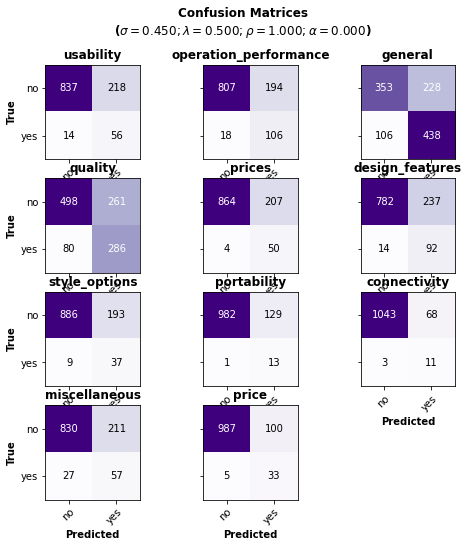

0.18804040404040404

In [14]:
clf = SS3()
clf.fit(X_train_enhanced, y_train)
Evaluation.clear_cache(clf)
Evaluation.test(clf, X_val, y_val)

In [15]:
s_l = span(0, 1, 10)
l_l = span(0, 5, 10)
p_l = span(0, 5, 10)
a_l = span(0, 1, 10)
best_s, best_l, best_p, best_a = Evaluation.grid_search(clf, X_train, y_train, s=s_l, l=l_l, p=p_l, a=a_l, n_grams=6)

Grid search: 100%|██████████| 10000/10000 [3:02:13<00:00,  1.09s/it]


Classification: 100%|██████████| 1125/1125 [00:00<00:00, 15258.72it/s]



                       precision    recall  f1-score   support

            usability       0.34      0.66      0.45        70
operation_performance       0.74      0.40      0.52       124
              general       0.74      0.63      0.68       544
              quality       0.70      0.65      0.67       366
               prices       0.43      0.59      0.50        54
      design_features       0.41      0.53      0.46       106
        style_options       0.38      0.46      0.42        46
          portability       0.26      0.79      0.39        14
         connectivity       0.48      0.71      0.57        14
        miscellaneous       0.61      0.27      0.38        84
                price       0.27      0.84      0.41        38

            micro avg       0.57      0.59      0.58      1460
            macro avg       0.48      0.59      0.49      1460
         weighted avg       0.64      0.59      0.59      1460
          samples avg       0.62      0.62      0.59

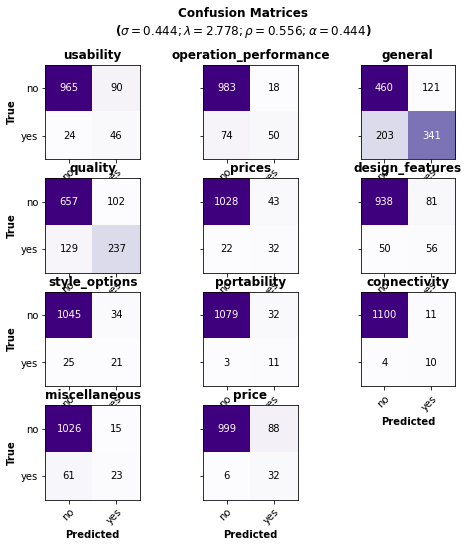

0.4936440933014737

In [16]:
clf.set_hyperparameters(s=best_s, l=best_l, p=best_p, a=best_a)
Evaluation.test(clf, X_val_enhanced, y_val, metric='f1-score')

In [17]:
print("Best s:", best_s, " Best l:", best_l, " Best p:", best_p, " Best a:", best_a)

Best s: 0.4444  Best l: 2.7778  Best p: 0.5556  Best a: 0.4444


Classification: 100%|██████████| 1125/1125 [00:00<00:00, 15256.16it/s]



                       precision    recall  f1-score   support

            usability       0.38      0.61      0.47        70
operation_performance       0.74      0.60      0.66       124
              general       0.72      0.74      0.73       544
              quality       0.59      0.78      0.67       366
               prices       0.20      0.85      0.32        54
      design_features       0.41      0.71      0.52       106
        style_options       0.39      0.46      0.42        46
          portability       0.69      0.79      0.73        14
         connectivity       0.69      0.64      0.67        14
        miscellaneous       0.57      0.36      0.44        84
                price       0.26      0.82      0.39        38

            micro avg       0.53      0.70      0.61      1460
            macro avg       0.51      0.67      0.55      1460
         weighted avg       0.60      0.70      0.63      1460
          samples avg       0.60      0.73      0.62

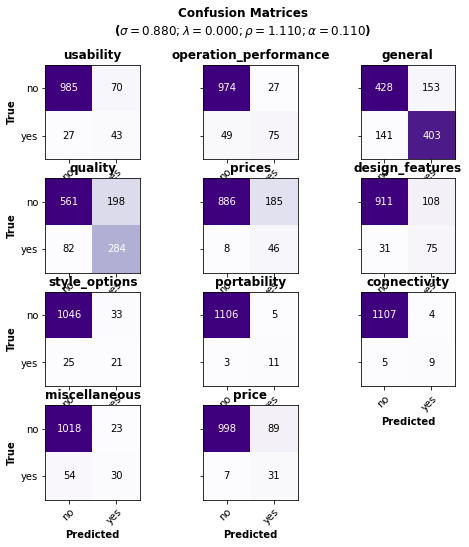

0.5480363809014194

In [18]:
clf.set_hyperparameters(s=0.88, l=0, p=1.11, a=0.11)
Evaluation.test(clf, X_val_enhanced, y_val, metric='f1-score')